# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random
from IPython.display import display, clear_output, update_display
import bayes_opt

from pmd_beamphysics import ParticleGroup
#from pmd_beamphysics.statistics import resample_particles
import pmd_beamphysics.statistics

from UTILITY_plotMod import plotMod, slicePlotMod
from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam
from UTILITY_setLattice import setLattice, getBendkG, getQuadkG, getSextkG

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

#Need to explicitly add non-MARKER places to save beam...
tao.cmd("set beam add_saved_at = DTOTR, XTCAVF, M2EX")

[]

In [3]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [4]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

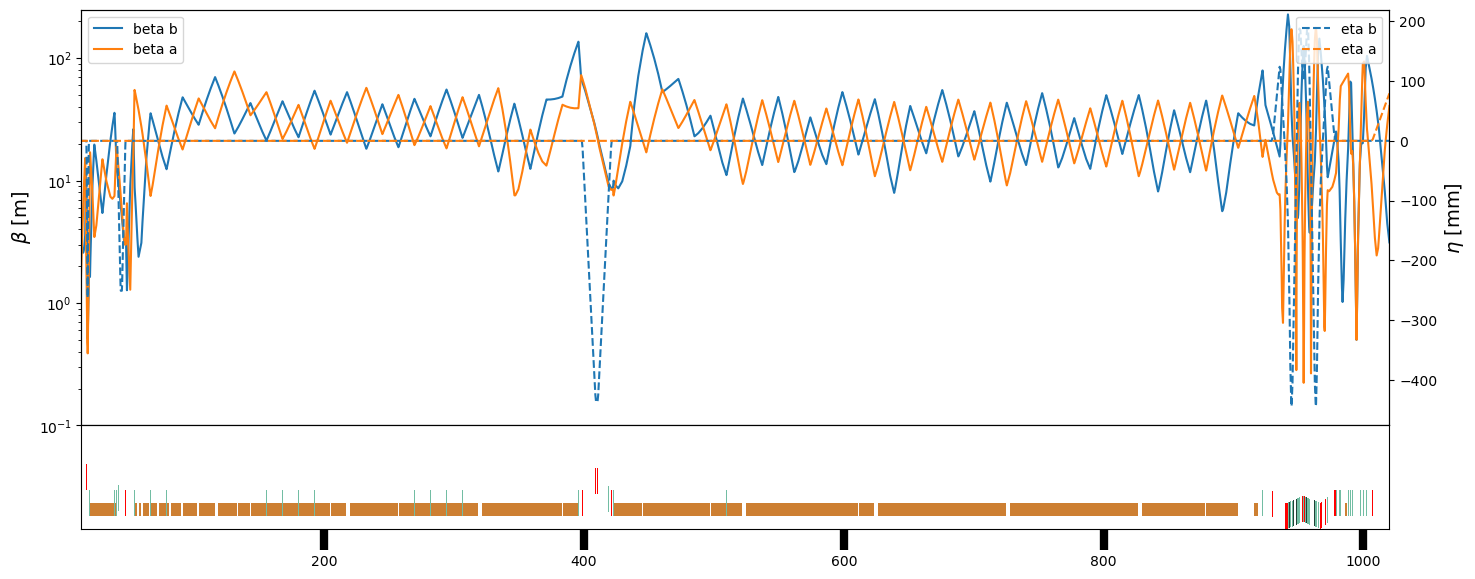

In [5]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

In [6]:
lastTrackedElement = "end"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')
#Can see present track_start and track_end values with `show beam`


#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [7]:
inputBeamFilePath = f'{filePath}/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5'

numMacroParticles = 10000

modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = numMacroParticles
)

tao.cmd(f'set beam_init position_file={filePath}/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

#Set lattice to my latest default config
setLattice(tao)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [8]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

sigmaX = PPENT.std("x")
sigmaY = PPENT.std("y")
sigmaZ = PPENT.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")

0.00015822248358793008, 1.8881259689375372e-05, 2.814810354851893e-05


# Set up to define a target current distribution

Sum counts: 9913


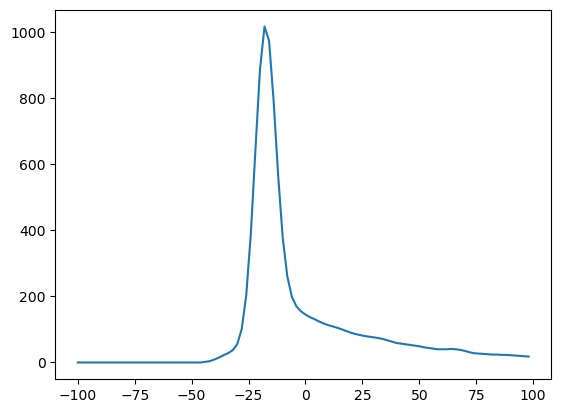

In [9]:
zData = PPENT.t * 3e8
zData = zData - np.mean(zData)


from scipy.ndimage import gaussian_filter1d
def histogramDataUnified(data):
    counts, bin_edges = np.histogram(data, range=(-100e-6,100e-6), bins = 100)

    #Optional: Gaussian blur
    counts = gaussian_filter1d(counts, 2.0)
    
    return counts, bin_edges

# Generate histogram data
counts, bin_edges = histogramDataUnified(zData)

# Print histogram data
# print("Counts:", counts)
# print("Bin edges:", bin_edges)

print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()

Sum counts: 9979


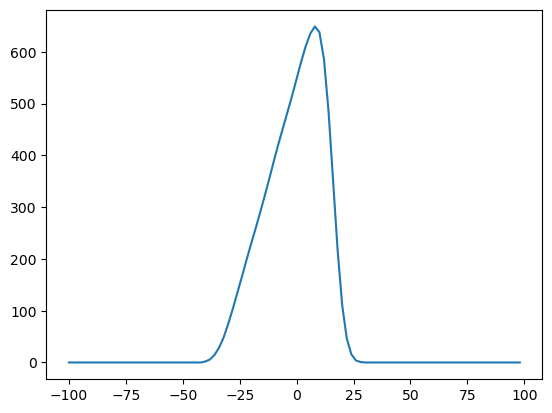

In [10]:
#Braindead way first; will deal with sampling from arb PDFs or whatever later
fakePop = np.random.rand(10*len(zData), 2) #Uniform random 2D
fakePop = [x for x, y in fakePop if x > y] #Make 1D triangle distribution
fakePop = 50e-6 * np.array(fakePop) #Length scale
fakePop = fakePop[:len(zData)] #Pare down
fakePop = fakePop - np.mean(fakePop) #Center



# Generate histogram data
counts, bin_edges = histogramDataUnified(fakePop)

# Print histogram data
# print("Counts:", counts)
# print("Bin edges:", bin_edges)

print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()


targetProfileCounts = counts #Define what we're aiming for

Sum counts: 9967


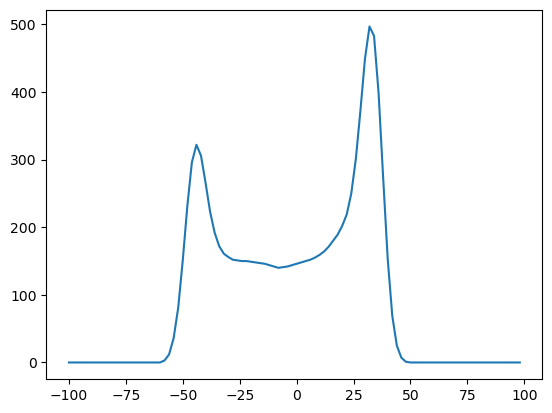

2001.8116794543887


In [11]:
setLattice(tao,
          L2PhaseSet = -34
          )



tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

zData = PPENT.t * 3e8
zData = zData - np.mean(zData)


# Generate histogram data
counts, bin_edges = histogramDataUnified(zData)


print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()

#Euclidean norm of difference between present and target histogram bin vectors
print(np.linalg.norm(targetProfileCounts - counts))

# Bayesian optimization

## Utility functions

In [12]:
def propagateToBEGBC20(
    centerXYatBEGBC20 = False    
): 

    ######################################################################################
    #First import "clean" beam and do modification at launch point
    ######################################################################################

    inputBeamFilePath = f'{filePath}/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5'

    tao.cmd('reinit beam')

    P = modifyAndSaveInputBeam(
        inputBeamFilePath,
        numMacroParticles = numMacroParticles,
        #betaX = launchBetaX,
        #alphaX = launchAlphaX,
        #betaY = launchBetaY,
        #alphaY = launchAlphaY
    )

    P.write(f'{filePath}/beams/activeBeamFile.h5')
    inputBeamFilePath = f'{filePath}/beams/activeBeamFile.h5'

    ##################################
    #Propagate to BEGBC20 and save result
    ##################################
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "BEGBC20"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    tao.cmd(f'set beam_init position_file={filePath}/beams/activeBeamFile.h5')
    tao.cmd('reinit beam')

    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    ##################################
    #Optional!! Center in x and y
    ##################################
    if centerXYatBEGBC20:
        P.x = P.x - np.mean(P.x)
        P.y = P.y - np.mean(P.y)
        P.px = P.px - np.mean(P.px)
        P.py = P.py - np.mean(P.py)
    
    P.write(f'{filePath}/beams/activeBeamFile.h5')

    return

In [13]:
def prepareToSimulateFromBEGBC20toEnd():
    #####################################################
    #Import the BEGBC20 beam and prepare to simulate to end
    #####################################################
    tao.cmd(f'set beam_init position_file={filePath}/beams/activeBeamFile.h5')
    tao.cmd(f'set beam_init track_start = BEGBC20')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

## Optimizer functions

In [14]:
#If we're not making changes upstream, we can just calculate once
makingChangesUpstreamOfBEGBC20 = True

if not makingChangesUpstreamOfBEGBC20:
    setLattice(tao) #Set lattice to current default config
    propagateToBEGBC20(centerXYatBEGBC20 = True)
    prepareToSimulateFromBEGBC20toEnd()

def dispersionCost(etaX, etapX, etaY, etapY):
    #This is an entirely made up way of including dispersion in the objective function
    #The expectation is that this value will range from 0 to 1 to derate the nominal maximizeMe

    lengthScale = 5 #A way to compare eta to etap; roughly the length of the region of interest in meters
    combinedDispersionTerm = abs(etaX) + abs(etaY) + lengthScale*(abs(etapX) + abs(etapY))

    dispersionCostThreshold = 100e-6
    exponentScaleFactor = 1e2

    return min(1, np.exp(-(combinedDispersionTerm - dispersionCostThreshold) * exponentScaleFactor))


def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e50 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue * 5

    if makingChangesUpstreamOfBEGBC20:

        try:
            propagateToBEGBC20(centerXYatBEGBC20 = True)
            prepareToSimulateFromBEGBC20toEnd()
            #tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
            #tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        except:
            return badValue * 4

    try:
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue * 3

    BEGBC20NumLiveParticles = tao.bunch_params("BEGBC20")['n_particle_live']
    PENTNumLiveParticles = tao.bunch_params("PENT")['n_particle_live']

    if PENTNumLiveParticles < 10:
        return badValue * 2 

    
    # 2024-05-22 NO NO NO! These bunch_params calls are actually returning lattice info because fuck me
    #PENTEmitX = tao.bunch_params("PENT")['twiss_norm_emit_x']
    #PENTEmitY = tao.bunch_params("PENT")['twiss_norm_emit_y']
    #PENTSigmaZ = tao.bunch_params("PENT")['twiss_sigma_z']

    # PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
    # PPENT = PPENT[PPENT.status==1]

    # PENTEmitX = PPENT["norm_emit_x"]
    # PENTEmitY = PPENT["norm_emit_y"]
    # PENTSigmaZ = PPENT["sigma_t"]*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z
    

    # #Instead of dealing with dispersion leakage directly, just check beam quality at multiple locations
    # #locationsToCheckBeam = ["MFFF", "KRK", "DBMARK67", "ENDFF20", "PIC_CENT", "FILG", "PENT", "PEXT", "BEGPDC", "ENDPDC", "BEGEDC", "ENDEDC", "M2EX"]
    # #locationsToCheckBeam = ["MFFF", "PENT", "M2EX"]
    # locationsToCheckBeam = ["PENT"]

    # for eleString in locationsToCheckBeam:
    #     P = ParticleGroup(data=tao.bunch_data(eleString))
    #     P = P[P.status==1]

    #     savedData[eleString+"EmitX"] = P["norm_emit_x"]
    #     savedData[eleString+"EmitY"] = P["norm_emit_y"]
    #     savedData[eleString+"SigmaZ"] = P["sigma_t"]*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z        
    #     #savedData[eleString+"MaximizeMe"] = maximizeMe = 1 / ( savedData[eleString+"EmitX"] * savedData[eleString+"EmitY"] * savedData[eleString+"SigmaZ"])

    #     #Dispersion values
    #     tmpStats = pmd_beamphysics.statistics.particle_twiss_dispersion(P, plane = "x")
    #     savedData[eleString+"etaX"] = tmpStats["eta_x"]
    #     savedData[eleString+"etapX"] = tmpStats["etap_x"]
    #     tmpStats = pmd_beamphysics.statistics.particle_twiss_dispersion(P, plane = "y")
    #     savedData[eleString+"etaY"] = tmpStats["eta_y"]
    #     savedData[eleString+"etapY"] = tmpStats["etap_y"]

    #     savedData[eleString+"dispersionCost"] = dispersionCost(savedData[eleString+"etaX"], savedData[eleString+"etapX"], savedData[eleString+"etaY"], savedData[eleString+"etapY"])


    #     savedData[eleString+"MaximizeMeBase"] = maximizeMe = 1 / ( savedData[eleString+"EmitX"] * savedData[eleString+"EmitY"] * savedData[eleString+"SigmaZ"])
    #     savedData[eleString+"MaximizeMe"] = savedData[eleString+"MaximizeMeBase"] * savedData[eleString+"dispersionCost"]
        
    
    # #This was added to stop division by zero errors
    # #if ( PENTEmitX * PENTEmitY * PENTSigmaZ ) == 0:
    # #    return badValue * 1.5
    
    # #maximizeMe = 1 / ( PENTEmitX * PENTEmitY * PENTSigmaZ)
    # #maximizeMe = 1 / PENTSigmaZ
    # maximizeMe = np.mean( [ savedData[eleString+"MaximizeMe"] for eleString in locationsToCheckBeam ] )
    # savedData["maximizeMe"] = maximizeMe



    #########################################################
    # 2024-06-25: Optimizing to target current profile shape
    #########################################################
    PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
    
    zData = PPENT.t * 3e8
    zData = zData - np.mean(zData)
    
    # Generate histogram data
    counts, bin_edges = histogramDataUnified(zData)
    savedData["currentProfileBinData"] = counts

    #(Inverse) Euclidean norm of difference between present and target histogram bin vectors
    maximizeMe = 1/np.linalg.norm(targetProfileCounts - counts)



    
    

    #Use charge loss to impose cost
    worstNumLiveParticles = PENTNumLiveParticles
    chargeFractionLiving = worstNumLiveParticles / BEGBC20NumLiveParticles

    if chargeFractionLiving < 0.98:
        #If a gradient is desired
        #maximizeMe += 0.1 * badValue * (1-chargeFractionLiving)

        #If it's just a threshold
        return badValue*0.5

    savedData["maximizeMe"] = maximizeMe    
    
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 

        
        # kwargs | { 

        # "BEGBC20NumLiveParticles": BEGBC20NumLiveParticles,
        # "PENTNumLiveParticles": PENTNumLiveParticlesTCAVOn,
            
        # "PENTEmitX": PENTEmitX,
        # "PENTEmitY": PENTEmitY,
        # "PENTSigmaZ": PENTSigmaZ,
            
        # "maximizeMe": maximizeMe
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    #})

    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()


    return maximizeMe



def optimizerWrapper( self,
                     L1PhaseSet, L2PhaseSet, 
                     #B1EkG, B2EkG, B3EkG,
                     Q1EkG, Q2EkG, Q3EkG, Q4EkG, Q5EkG, Q6EkG,
                     S1ELkG, S2ELkG, S3ELkG, 
                     # S3ERkG, S2ERkG, S1ERkG,
                     **kwargs ):
    return specificOptimizer(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            
            #"B1EkG": B1EkG,
            #"B2EkG": B2EkG,
            #"B3EkG": B3EkG,
            
            "Q1EkG" : Q1EkG,
            "Q2EkG" : Q2EkG,
            "Q3EkG" : Q3EkG,
            "Q4EkG" : Q4EkG,
            "Q5EkG" : Q5EkG,
            "Q6EkG" : Q6EkG,
            
            "S1ELkG": S1ELkG,
            "S2ELkG": S2ELkG,
            "S3ELkG": S3ELkG,
            # "S3ERkG": S3ERkG,
            # "S2ERkG": S2ERkG,
            # "S1ERkG": S1ERkG,
            "S3ERkG": S3ELkG, #Symmetry approx
            "S2ERkG": S2ELkG, #Symmetry approx
            "S1ERkG": S1ELkG, #Symmetry approx
            
        }
    )

In [15]:
# setLattice(tao, **{
#             "Q5FFkG": -192,
#             "Q4FFkG": -162,
#             "Q3FFkG": 106,
#             "Q2FFkG": 121,
#             "Q1FFkG": -209,
#             "Q0FFkG": 121,
#             "Q0DkG": -139,
#             "Q1DkG": 225,
#             "Q2DkG": -139
# })

# tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
# tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

# XTCAVSigmaX = tao.bunch_params("XTCAVF")['twiss_sigma_x']
# BEGBC20NumLiveParticles = tao.bunch_params("BEGBC20")['n_particle_live']
# PENTNumLiveParticlesTCAVOn = tao.bunch_params("PENT")['n_particle_live']

# print(1e6*XTCAVSigmaX)
# print(PENTNumLiveParticlesTCAVOn)

## Do optimization

### General optimizer setup

In [16]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None

        

    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
#boundsRange = 0.5
quadBoundsRange = 0.25
sextBoundsRange = 0.5

# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    'L1PhaseSet': (-40, -20),
    'L2PhaseSet': (-50, -30),
    
    #"B1EkG": makeBoundsTuple(boundsRange, 7.533),
    #"B2EkG": makeBoundsTuple(boundsRange, -10.942),
    #"B3EkG": makeBoundsTuple(boundsRange, 3.409),

    "Q1EkG": makeBoundsTuple(quadBoundsRange, 161.311),
    "Q2EkG": makeBoundsTuple(quadBoundsRange, -154.229),
    "Q3EkG": makeBoundsTuple(quadBoundsRange, 110.217),
    "Q4EkG": makeBoundsTuple(quadBoundsRange, 132.268),
    "Q5EkG": makeBoundsTuple(quadBoundsRange, -23.373),
    "Q6EkG": makeBoundsTuple(quadBoundsRange, -142.271),

     "S1ELkG": makeBoundsTuple(sextBoundsRange, 804.871),
     "S2ELkG": makeBoundsTuple(sextBoundsRange, -2049.489),
     "S3ELkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
     # "S3ERkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
     # "S2ERkG": makeBoundsTuple(sextBoundsRange, -2049.489),
     # "S1ERkG": makeBoundsTuple(sextBoundsRange, 804.871),
}

### Bayesian optimization

In [17]:
# optimizer = bayes_opt.BayesianOptimization(
#     f=problem.optimizerWrapper,
#     pbounds=pbounds,
#     random_state=7,
#     allow_duplicate_points=True, #2024-04-26 it was whining about this,
#     verbose = 0 #2024-05-22: Make it quiet
# )

# #Initial point(s) to check
# # optimizer.probe(
# #     params={
# # 'Q1EkG': 117.05888832887702,
# #  'Q2EkG': -161.08070347179788,
# #  'Q3EkG': 123.62696608961151,
# #  'Q4EkG': 99.94203817364581,
# #  'Q5EkG': -31.456534919110677,
# #  'Q6EkG': -105.01493924928589,
# #  'S1ELkG': 453.142910378237,
# #  'S2ELkG': -1988.4701652598128,
# #  'S3ELkG': -985.7586439934659,
# #  'S3ERkG': -564.5394965036853,
# #  'S2ERkG': -1592.1135118613981,
# #  'S1ERkG': 869.2610562040793
# # },
# #     lazy=True,
# # )

# #Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# #and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
# boInitialKappa = 10 + 0*10.
# boFinalKappa = 1e-3 + 0*0.1
# boNumIter = 100
# boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

# acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
#                                    kappa=boInitialKappa,         #Default 2.576
#                                    xi=0.0,              #Default 0
#                                    kappa_decay=boKappaDecay,       #Default 0
#                                    kappa_decay_delay=0  #Default 0                     
#                                           )


# optimizer.maximize(
#     init_points=50, #Initial, random points
#     n_iter=boNumIter,
#     acquisition_function=acquisition_function
# )

### Differential evolution

'Total Num Evals: 561'

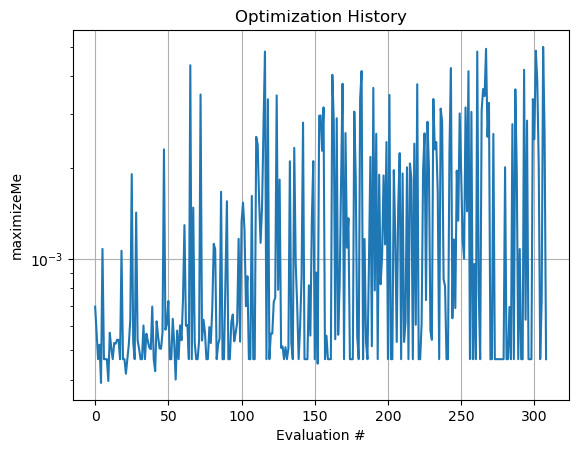

differential_evolution step 1: f(x)= -0.000695991
differential_evolution step 2: f(x)= -0.00107974
differential_evolution step 3: f(x)= -0.00107974
differential_evolution step 4: f(x)= -0.00107974
differential_evolution step 5: f(x)= -0.00107974
differential_evolution step 6: f(x)= -0.00190486
differential_evolution step 7: f(x)= -0.00190486
differential_evolution step 8: f(x)= -0.00190486
differential_evolution step 9: f(x)= -0.00229957
differential_evolution step 10: f(x)= -0.00229957
differential_evolution step 11: f(x)= -0.00435607
differential_evolution step 12: f(x)= -0.00435607
differential_evolution step 13: f(x)= -0.00435607
differential_evolution step 14: f(x)= -0.00435607
differential_evolution step 15: f(x)= -0.00435607
differential_evolution step 16: f(x)= -0.00435607
differential_evolution step 17: f(x)= -0.00435607
differential_evolution step 18: f(x)= -0.00435607
differential_evolution step 19: f(x)= -0.00435607
differential_evolution step 20: f(x)= -0.00435607
differen

In [18]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#Optional: Define list of starting points
totalPopSize = 10  # Total population size
numDimensions = len(bounds)  # Number of parameters




#Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]
    mean = (high + low) / 2
    std_dev = (high - low) / 10
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
populationDE = np.vstack([populationDE, [ np.mean(i) for i in bounds ]])

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evoluation is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

result = differential_evolution(
    wrapperDE, 
    bounds,
    #strategy='best1bin', 
    maxiter=50, #Actual number of evals = maxiter * num dimensions * popsize
    #popsize=1, #Actual population = num (unequal) dimensions * popsize
    #tol=0.01, 
    #mutation=(0.5, 1), 
    #recombination=0.7, 
    disp=True,
    polish = False, 
    init = populationDE #"sobol" #Default is "latinhypercube"
)



print(problem.history) 

## Check out results

In [19]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
problem.history.to_csv('output_data.csv', index=False)

bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

#Using triple quotes lets us use " inside the f-string
#print(f"""\n{1e6*bestConfigData["PENTEmitX"]}, {1e6*bestConfigData["PENTEmitY"]}, {1e6*bestConfigData["PENTSigmaZ"]}""")


setLattice(tao, **bestConfigDict)


tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
PPENT = PPENT[PPENT.status==1]

L1PhaseSet                                                      -29.198097
L2PhaseSet                                                      -39.828964
Q1EkG                                                           173.216727
Q2EkG                                                          -151.027898
Q3EkG                                                           103.164889
Q4EkG                                                           148.363163
Q5EkG                                                           -23.184552
Q6EkG                                                          -135.570854
S1ELkG                                                          691.241867
S2ELkG                                                        -1930.666098
S3ELkG                                                         -998.549168
S3ERkG                                                         -998.549168
S2ERkG                                                        -1930.666098
S1ERkG                   

In [20]:
bestConfigDict

{'L1PhaseSet': -29.19809727434996,
 'L2PhaseSet': -39.82896406294125,
 'Q1EkG': 173.21672732528026,
 'Q2EkG': -151.02789784551092,
 'Q3EkG': 103.16488894300518,
 'Q4EkG': 148.36316323574786,
 'Q5EkG': -23.184551841781104,
 'Q6EkG': -135.5708539259795,
 'S1ELkG': 691.2418671344504,
 'S2ELkG': -1930.66609843532,
 'S3ELkG': -998.5491675796588,
 'S3ERkG': -998.5491675796588,
 'S2ERkG': -1930.66609843532,
 'S1ERkG': 691.2418671344504,
 'currentProfileBinData': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2,   5,  12,  22,  37,  55,  73,  89, 105, 124, 150,
        184, 224, 267, 307, 341, 368, 392, 415, 438, 463, 493, 530, 575,
        623, 660, 663, 615, 515, 386, 258, 159,  94,  58,  40,  32,  28,
         27,  26,  25,  22,  18,  14,  11,   8,   6,   5,   3,   2,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   

In [21]:
# display(plotMod(PPENT, 'x', 'y',  bins=300))
# display(plotMod(PPENT, 'x', 'pz', bins=300))
# display(plotMod(PPENT, 'x', 'px', bins=300))
# display(plotMod(PPENT, 'y', 'py', bins=300))
# display(plotMod(PPENT, 'delta_t', 'pz', bins=300))
# display(slicePlotMod(PPENT, 'norm_emit_x',n_slice=100))

Sum counts: 9974


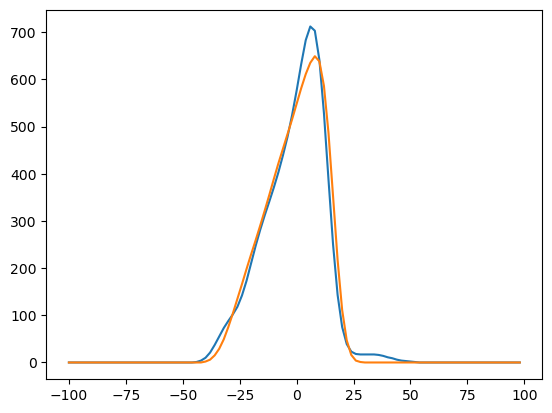

235.58650216003463


In [22]:
zData = PPENT.t * 3e8
zData = zData - np.mean(zData)


# Generate histogram data
counts, bin_edges = histogramDataUnified(zData)


print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.plot(1e6*(bin_edges[:-1]),targetProfileCounts)
plt.show()

#Euclidean norm of difference between present and target histogram bin vectors
print(np.linalg.norm(targetProfileCounts - counts))

In [23]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
PPENT = PPENT[PPENT.status==1]
print(PPENT.norm_emit_x)
print(tao.bunch_params("PENT")['twiss_norm_emit_x'])

0.0002216039426538418
1.71232966612024e-05


In [24]:
PBEGBC20 =  ParticleGroup(data=tao.bunch_data("BEGBC20"))
PBEGBC20 = PBEGBC20[PBEGBC20.status==1]
print(PBEGBC20.norm_emit_x)
print(tao.bunch_params("BEGBC20")['twiss_norm_emit_x'])

5.98171186374846e-06
5.84418525426876e-06


In [25]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
PPENT = PPENT[PPENT.status==1]
print(np.std(PPENT.x))
print(tao.bunch_params("PENT")['twiss_sigma_x'])

0.00010185711240484448
2.66564095328529e-05


In [26]:
PBEGBC20 =  ParticleGroup(data=tao.bunch_data("BEGBC20"))
PBEGBC20 = PBEGBC20[PBEGBC20.status==1]
print(np.std(PBEGBC20.x))
print(tao.bunch_params("BEGBC20")['twiss_sigma_x'])

6.024143491314296e-05
5.95255719802505e-05


In [27]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
PPENT = PPENT[PPENT.status==1]
print(np.std(PPENT.y))
print(tao.bunch_params("PENT")['twiss_sigma_y'])

7.680290255529519e-05
7.68028609814215e-05


In [28]:
print(np.std(tao.bunch_data("PENT")["x"]))
print(tao.bunch_params("PENT")['twiss_sigma_x'])

0.00010185711240484448
2.66564095328529e-05


In [29]:
np.std(tao.bunch_data("PENT")["weight"])

0.0

In [30]:
np.std(tao.bunch_data("PENT")["status"])

0.0

In [31]:
print(np.std(tao.bunch_data("BEGBC20")["x"]))
print(tao.bunch_params("BEGBC20")['twiss_sigma_x'])

6.024143491314296e-05
5.95255719802505e-05


In [32]:
P =  ParticleGroup(data=tao.bunch_data("PENT"))
P = P[P.status==1]
print( P["norm_emit_x"] )
print( P["norm_emit_y"] )
print( P["norm_emit_x"]*P["norm_emit_y"]*P["sigma_t"] )

0.0002216039426538418
1.7359348279039876e-05
1.620472318577586e-22


In [33]:
P =  ParticleGroup(data=tao.bunch_data("MFFF"))
P = P[P.status==1]
print( P["norm_emit_x"] )
print( P["norm_emit_y"] )
print( P["norm_emit_x"]*P["norm_emit_y"]*P["sigma_t"] )

0.0001045757180032711
2.20836330381847e-05
7.297246468668228e-23


In [34]:
P =  ParticleGroup(data=tao.bunch_data("M2EX"))
P = P[P.status==1]
print( P["norm_emit_x"] )
print( P["norm_emit_y"] )
print( P["norm_emit_x"]*P["norm_emit_y"]*P["sigma_t"] )

0.00045220536342540496
3.195291512100088e-05
1.2615330848354632e-21
